Using cpu device
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 62.9         |
|    ep_rew_mean          | 62.9         |
| time/                   |              |
|    fps                  | 4655         |
|    iterations           | 20           |
|    time_elapsed         | 2            |
|    total_timesteps      | 10240        |
| train/                  |              |
|    approx_kl            | 0.0020543044 |
|    clip_fraction        | 0.00254      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.618       |
|    explained_variance   | 0.019        |
|    learning_rate        | 0.0003       |
|    loss                 | 55.4         |
|    n_updates            | 190          |
|    policy_gradient_loss | -0.00548     |
|    value_loss           | 118          |
------------------------------------------
------------------------------------------
| rollout/                |          

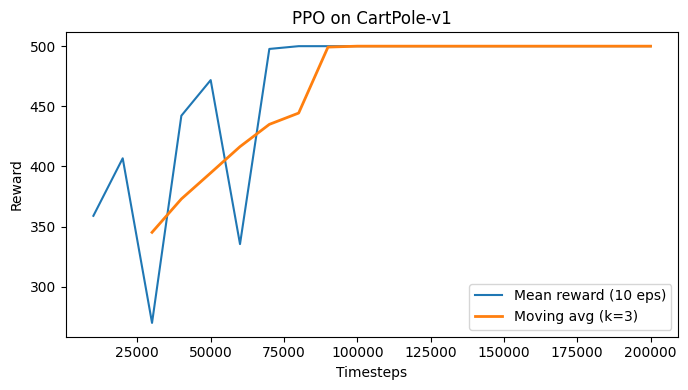

In [17]:
import gymnasium as gym
import numpy as np, matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy

SEED = 1234
train_env = make_vec_env("CartPole-v1", n_envs=4, seed=SEED)
eval_env  = gym.make("CartPole-v1")
model = PPO(
    "MlpPolicy", 
    train_env, 
    verbose=1, 
    seed=SEED, 
    n_steps=128, 
    batch_size=256, 
    gamma=0.99, 
    gae_lambda=0.95, 
    ent_coef=0.01)

timesteps   = []
mean_rewards = []
EVAL_EVERY, TOTAL_STEPS = 10_000, 200_000
for step in range(EVAL_EVERY, TOTAL_STEPS+1, EVAL_EVERY):
    model.learn(total_timesteps=EVAL_EVERY, log_interval=20, reset_num_timesteps=False, progress_bar=False)
    m, s = evaluate_policy(model, eval_env, n_eval_episodes=10, deterministic=True)
    timesteps.append(step); mean_rewards.append(m)
model.save("ppo_cartpole")

# Convergence plot (moving average)
def movavg(x, k=3):
    if len(x) < k: return x
    return np.convolve(x, np.ones(k)/k, mode="valid")

plt.figure(figsize=(7,4))
plt.plot(timesteps, mean_rewards, label="Mean reward (10 eps)")
ma = movavg(mean_rewards, k=3); tx = timesteps[len(timesteps)-len(ma):]
plt.plot(tx, ma, linewidth=2, label="Moving avg (k=3)")
plt.xlabel("Timesteps"); plt.ylabel("Reward"); plt.title("PPO on CartPole-v1")
plt.legend(); plt.tight_layout(); plt.savefig("convergence.png")


In [18]:
import gymnasium as gym
from stable_baselines3 import PPO

SEED = 1234
model = PPO.load("ppo_cartpole")

# single env for recording
env = gym.make("CartPole-v1", render_mode="rgb_array")
env = gym.wrappers.RecordVideo(env, video_folder="videos", episode_trigger=lambda e: True)
obs, info = env.reset(seed=SEED)

done = False
while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

env.close()
print("Saved video(s) in ./videos")


Saved video(s) in ./videos
